In [1]:
!pip install cirq bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [2]:
import cirq
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from scipy.optimize import minimize
from bayes_opt import BayesianOptimization

In [3]:
def select_gate_for_application(application):
    # Define the mapping from application to gates
    application_to_gate = {
        'coin flip': 'H',
        'bit flip': 'X',
        'phase flip': 'Z',
        'bitwise not': 'Y'
    }

    # Convert application to lowercase and select the appropriate gate
    gate_type = application_to_gate.get(application.lower(), 'H')  # Default to Hadamard gate if not found
    return gate_type

In [4]:
def create_circuit(gate_type):
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit()

    if gate_type == 'H':
        circuit.append(cirq.H(qubit))
    elif gate_type == 'X':
        circuit.append(cirq.X(qubit))
    elif gate_type == 'Y':
        circuit.append(cirq.Y(qubit))
    elif gate_type == 'Z':
        circuit.append(cirq.Z(qubit))
    else:
        print("Invalid gate type. Defaulting to Hadamard gate.")
        circuit.append(cirq.H(qubit))

    circuit.append(cirq.measure(qubit, key='result'))
    return circuit

In [5]:
def minimize_circuit_depth_greedy(circuit):
    # Simplified greedy approach: For each gate, place it in the earliest possible layer
    qubits = list(circuit.all_qubits())
    layers = []

    # Initialize an empty dictionary to store qubit states and their corresponding gates
    qubit_layers = {q: [] for q in qubits}

    for moment in circuit:
        # Create a new moment for optimized circuit
        new_moment = cirq.Moment()

        for op in moment.operations:
            qubit = op.qubits[0]
            if len(qubit_layers[qubit]) == 0:
                # If no previous gate on this qubit, add to the new moment
                new_moment = new_moment.with_operation(op)
                qubit_layers[qubit].append(op)
            else:
                # If there is a previous gate, check if it conflicts with current gate
                if all(op not in layer for layer in qubit_layers[qubit]):
                    new_moment = new_moment.with_operation(op)
                    qubit_layers[qubit].append(op)

        if new_moment.operations:
            layers.append(new_moment)

    optimized_circuit = cirq.Circuit(layers)
    return optimized_circuit


In [6]:

def gate_count_reduction(circuit):
    # Template Matching
    templates = {
        'H': cirq.Circuit([cirq.H(cirq.GridQubit(0, 0))]),
        'X': cirq.Circuit([cirq.X(cirq.GridQubit(0, 0))]),
        'Z': cirq.Circuit([cirq.Z(cirq.GridQubit(0, 0))]),
        'Y': cirq.Circuit([cirq.Y(cirq.GridQubit(0, 0))])
    }

    # Simplified peephole optimization
    optimized_circuit = cirq.Circuit()
    operations = set()

    for moment in circuit:
        new_moment = cirq.Moment()
        for op in moment.operations:
            if op not in operations:
                new_moment = new_moment.with_operation(op)
                operations.add(op)
        if new_moment.operations:
            optimized_circuit = optimized_circuit + new_moment

    return optimized_circuit

In [7]:
def gradient_descent_optimizer(circuit):
    def cost_function(params):
        # Define a cost function for the circuit
        # For demonstration, use a dummy cost function that returns a constant value
        return np.sum(params**2)  # Example cost function

    initial_params = np.zeros(1)  # Example initial parameters
    result = minimize(cost_function, initial_params, method='BFGS')
    optimized_params = result.x
    return optimized_params

In [8]:
def bayesian_optimization_optimizer(circuit):
    def cost_function(param):
        # Define a cost function for Bayesian optimization
        # For demonstration, use a dummy cost function
        return -param**2 + 1  # Example cost function

    optimizer = BayesianOptimization(
        f=cost_function,
        pbounds={'param': (-1, 1)},
        random_state=1,
    )
    optimizer.maximize(init_points=5, n_iter=10)
    best_params = optimizer.max['params']
    return best_params

In [9]:
def visualize_results(results):
    measurements = results.measurements['result'].flatten()
    counts = Counter(measurements)
    total_counts = sum(counts.values())

    print("Measurement Results:", dict(counts))

    # Plot the results
    fig, ax = plt.subplots()
    bars = ax.bar(counts.keys(), counts.values(), color=['blue', 'orange'])

    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_counts) * 100
        ax.text(bar.get_x() + bar.get_width() / 2, height,
                f'{percentage:.2f}%',
                ha='center', va='bottom')

    # Determine the probable result
    probable_result = max(counts.items(), key=lambda x: x[1])[0]
    print(f"Most probable result: {probable_result}")

    # Additional formatting
    ax.set_xlabel('Measurement Result')
    ax.set_ylabel('Count')
    ax.set_title('Measurement Results Histogram')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['0', '1'])

    plt.show()

In [12]:
def main():
    print("Ripples")

    # Get user input for the application
    application = input("Enter the application (e.g., 'coin flip', 'bit flip'): ")

    # Determine the appropriate gate for the given application
    gate_type = select_gate_for_application(application)
    print(f"Selected Gate for '{application}': {gate_type}")

    # Get user input for the number of repetitions
    try:
        repetitions = int(input("Enter the number of repetitions for the simulation: "))
    except ValueError:
        print("Invalid number. Defaulting to 1024 repetitions.")
        repetitions = 1024

    # Create and print the circuit
    circuit = create_circuit(gate_type)
    print("Quantum Circuit:")
    print(circuit)

    # Ask user for optimization method
    optimization_method = input("Select optimization method (depth reduction/gate count reduction/parameter optimization/none): ").strip().lower()

    if optimization_method == 'depth reduction':
        circuit = minimize_circuit_depth_greedy(circuit)
        print("Optimized Quantum Circuit (Depth Reduction):")
        print(circuit)
    elif optimization_method == 'gate count reduction':
        circuit = gate_count_reduction(circuit)
        print("Optimized Quantum Circuit (Gate Count Reduction):")
        print(circuit)
    elif optimization_method == 'parameter optimization':
        param_method = input("Select parameter optimization method (gradient descent/bayesian optimization): ").strip().lower()
        if param_method == 'gradient descent':
            optimized_params = gradient_descent_optimizer(circuit)
            print(f"Optimized Parameters (Gradient Descent): {optimized_params}")
        elif param_method == 'bayesian optimization':
            best_params = bayesian_optimization_optimizer(circuit)
            print(f"Best Parameters (Bayesian Optimization): {best_params}")
        else:
            print("Invalid parameter optimization method.")
    else:
        print("No optimization applied.")

    # Simulate the circuit
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=repetitions)

    # Visualize the results
    visualize_results(result)

Ripples
Enter the application (e.g., 'coin flip', 'bit flip'): coin flip
Selected Gate for 'coin flip': H
Enter the number of repetitions for the simulation: 3
Quantum Circuit:
(0, 0): ───H───M('result')───
Select optimization method (depth reduction/gate count reduction/parameter optimization/none): parameter optimization
Select parameter optimization method (gradient descent/bayesian optimization): gradient descent
Optimized Parameters (Gradient Descent): [0.]
Measurement Results: {0: 2, 1: 1}
Most probable result: 0


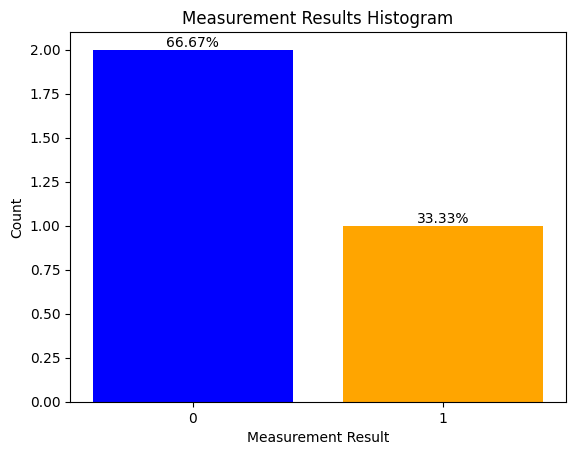

In [13]:

if __name__ == "__main__":
    main()